In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import hls4ml
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']

2023-04-20 12:59:51.470753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-20 12:59:51.470770: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ej/workspace/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
anomaly_class = {
    'bkg': 0,
    'glitches_new': 1
}

def readfile(anomaly_type):
  # only look at L1 for now
  data = np.load(anomaly_type+'.npy')[:,0,:]
  ids = np.full(data.shape[0], anomaly_class[anomaly_type], dtype=int)  
  return data, ids


x = np.array([])
y = np.array([])
for anom in anomaly_class.keys():
  x_anom, y_anom = readfile(anom)
  x = np.concatenate((x, x_anom), axis=0) if x.size else x_anom
  y = np.concatenate((y, y_anom), axis=0) if y.size else y_anom

In [3]:
# choose the split
split = 0.2

def split_train_test(x, y, split):
  split = int(x.shape[0]*(1-split))
  x_train, y_train = x[:split,:], y[:split]
  x_test, y_test = x[split:,:], y[split:]
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
  x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
  return x_train, y_train, x_test, y_test

np.random.seed(3)
idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]


x_train, y_train, x_test, y_test = split_train_test(x, y, split)

n_classes = len(anomaly_class.values())

# mix events
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [4]:
from tensorflow.keras.models import load_model
model = load_model('LIGO_transformer_based_classifier_v3.h5')

2023-04-20 12:59:52.736454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 12:59:52.736977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-20 12:59:52.737031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-20 12:59:52.737075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-20 12:59:52.737116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 100, 4)       8           ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 100, 4)      8           ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 100, 4)      612         ['layer_normalization[0][0]',

In [6]:
auc_arr = np.array([])
int_bit = 6
x_test1=np.ascontiguousarray(x_test[100:200,:,:])
y_keras = model.predict(x_test1)
y_test_binary = np.where(y_keras > 0.5, 1, 0)
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'GW_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        if 'layer_norm' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,11>'
        if 'dense_8' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['exp_range'] = 8

    hls_config['LayerName']['layer_normalization']['table_range'] = 1
    hls_config['LayerName']['layer_normalization_1']['table_range'] = 4
    hls_config['LayerName']['layer_normalization_2']['table_range'] = 3
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 7
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 4
    print(hls_config)
    #If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
    # hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
    # plotting.print_dict(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

4/4 [==============================] - 0s 5ms/step
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activati

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done


In [7]:
print(auc_arr)
int6 = auc_arr

[0.04    0.02065 0.0204  0.2911  0.9999  1.      0.9991  0.9947  0.9996 ]


In [8]:
auc_arr = np.array([])
int_bit = 7
x_test1=np.ascontiguousarray(x_test[100:200,:,:])
y_keras = model.predict(x_test1)
y_test_binary = np.where(y_keras > 0.5, 1, 0)
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'GW_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        if 'layer_norm' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,11>'
        if 'dense_8' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['exp_range'] = 8

    hls_config['LayerName']['layer_normalization']['table_range'] = 1
    hls_config['LayerName']['layer_normalization_1']['table_range'] = 4
    hls_config['LayerName']['layer_normalization_2']['table_range'] = 3
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 7
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 4
    print(hls_config)
    #If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
    # hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
    # plotting.print_dict(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

4/4 [==============================] - 0s 6ms/step
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activati

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done


In [9]:
print(auc_arr)
int7 = auc_arr

[0.04    0.0303  0.04    0.3101  0.98935 0.9999  0.9999  0.992   1.     ]


In [10]:
auc_arr = np.array([])
int_bit = 8
x_test1=np.ascontiguousarray(x_test[100:200,:,:])
y_keras = model.predict(x_test1)
y_test_binary = np.where(y_keras > 0.5, 1, 0)
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'GW_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        if 'layer_norm' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,11>'
        if 'dense_8' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['exp_range'] = 8

    hls_config['LayerName']['layer_normalization']['table_range'] = 1
    hls_config['LayerName']['layer_normalization_1']['table_range'] = 4
    hls_config['LayerName']['layer_normalization_2']['table_range'] = 3
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 7
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 4
    print(hls_config)
    #If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
    # hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
    # plotting.print_dict(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

4/4 [==============================] - 0s 6ms/step
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activati

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done


In [11]:
print(auc_arr)
int8 = auc_arr

[0.04    0.04    0.04    0.29385 0.9999  1.      1.      0.9921  1.     ]


In [12]:
auc_arr = np.array([])
int_bit = 9
x_test1=np.ascontiguousarray(x_test[100:200,:,:])
y_keras = model.predict(x_test1)
y_test_binary = np.where(y_keras > 0.5, 1, 0)
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'GW_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        if 'layer_norm' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,11>'
        if 'dense_8' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['exp_range'] = 8

    hls_config['LayerName']['layer_normalization']['table_range'] = 1
    hls_config['LayerName']['layer_normalization_1']['table_range'] = 4
    hls_config['LayerName']['layer_normalization_2']['table_range'] = 3
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 7
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 4
    print(hls_config)
    #If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
    # hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
    # plotting.print_dict(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

4/4 [==============================] - 0s 6ms/step
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activati

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done


In [13]:
print(auc_arr)
int9 = auc_arr

[0.04    0.02015 0.04    0.2963  1.      1.      1.      1.      1.     ]


In [14]:
auc_arr = np.array([])
int_bit = 9
x_test1=np.ascontiguousarray(x_test[100:200,:,:])
y_keras = model.predict(x_test1)
y_test_binary = np.where(y_keras > 0.5, 1, 0)
for i in range(2, 19, 2):
    precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)
    dirc = 'GW_precision/{}int_{}frac'.format(int_bit, i)
    #First, the baseline model
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    # Set the precision and reuse factor for the full model
    hls_config['Model']['Precision'] = precision
    hls_config['Model']['ReuseFactor'] = 1
    hls_config['Model']['Strategy'] = 'Resource'

    for Layer in hls_config['LayerName'].keys():
        hls_config['LayerName'][Layer]['Precision'] = precision
        hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
        hls_config['LayerName'][Layer]['weight'] = precision
        hls_config['LayerName'][Layer]['scale'] = precision
        hls_config['LayerName'][Layer]['bias'] = precision
        if 'layer_norm' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
        if 'multi_head_attention' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<18,8>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['exp_range'] = 4
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<22,11>'
        if 'dense_8' in Layer:
            hls_config['LayerName'][Layer]['table_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['accum_t'] = 'ap_fixed<26,13>'
            hls_config['LayerName'][Layer]['inv_range'] = 256
            hls_config['LayerName'][Layer]['table_size'] = 2048
            hls_config['LayerName'][Layer]['exp_range'] = 8

    hls_config['LayerName']['layer_normalization']['table_range'] = 1
    hls_config['LayerName']['layer_normalization_1']['table_range'] = 4
    hls_config['LayerName']['layer_normalization_2']['table_range'] = 3
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 7
    hls_config['LayerName']['layer_normalization_3']['table_range'] = 4
    print(hls_config)
    #If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
    # hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
    # plotting.print_dict(hls_config)

    cfg = hls4ml.converters.create_config(backend='Vivado')
    cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
    cfg['HLSConfig']  = hls_config
    cfg['KerasModel'] = model
    cfg['OutputDir']  = dirc
    cfg['Part'] = 'xcvu13p-fhga2104-2L-e'

    hls_model = hls4ml.converters.keras_to_hls(cfg)
    hls_model.compile()
    y_hls = hls_model.predict(np.ascontiguousarray(x_test1, dtype=np.float32))
    fpr, tpr, thresholds = roc_curve(y_test_binary.ravel(), y_hls.ravel())
    roc_auc = auc(fpr, tpr)
    auc_arr = np.append(auc_arr, roc_auc)

4/4 [==============================] - 0s 6ms/step
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activati

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: layer_normalization, layer type: LayerNormalization
Layer name: multi_head_attention, layer type: MultiHeadAttention
Layer name: add, layer type: Add
Layer name: layer_normalization_1, layer type: LayerNormalization
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
Layer name: add_1, layer type: Add
Layer name: layer_normalization_2, layer type: LayerNormalization
Layer name: multi_head_attention_1, layer type: MultiHeadAttention
Layer name: add_2, layer type: Add
Layer name: layer_normalization_3, layer type: LayerNormalization
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: dense_4, layer type: Dense
  -> Activation (linear), layer name: dense_4
Layer name: a

Done


In [15]:
print(auc_arr)
int10 = auc_arr

[0.04    0.02015 0.04    0.2963  1.      1.      1.      1.      1.     ]


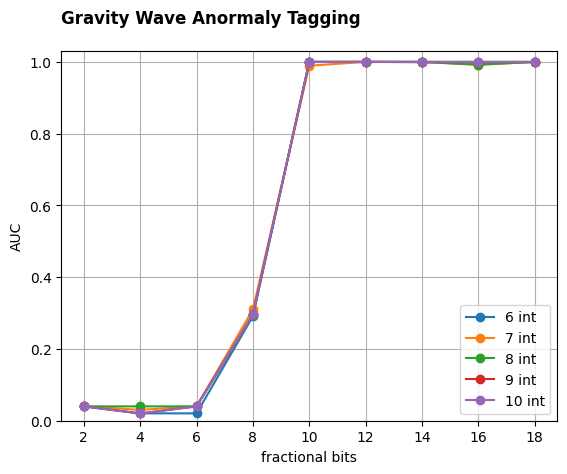

In [18]:
fig, ax = plt.subplots()
x_axis = [2,4,6,8,10,12,14,16,18]
ax.plot(x_axis, int6, "-o", label = "6 int")
ax.plot(x_axis, int7, "-o", label = '7 int')
ax.plot(x_axis, int8, "-o", label = '8 int')
ax.plot(x_axis, int9, "-o", label = '9 int')
ax.plot(x_axis, int10, "-o", label = '10 int')

ax.legend(loc='lower right')
ax.set_xlabel("fractional bits")
ax.set_ylabel("AUC")

# Set the title and adjust its position
ax.set_title("Gravity Wave Anormaly Tagging", loc='left', fontweight='bold', pad=20)

ax.grid()
ax.set_ylim([0.0, 1.03])
plt.show()